# Phase One: Libraries and GEE Setup

In [ ]:

#  STEP 1: Install Required Dependencies
!pip install -q earthengine-api
!pip install -q geemap
!pip install -q tensorflow
!pip install -q albumentations
!pip install -q rasterio
!pip install -q opencv-python-headless


In [ ]:
!pip install rasterio numpy pillow tqdm


In [ ]:
!pip install segmentation-models-pytorch albumentations --quiet

import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import jaccard_score
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [ ]:

import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm


In [ ]:
import ee
import geemap
import tensorflow as tf
import albumentations as A
import rasterio
import cv2
import os
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_mobilenet_v3_large


import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 0


In [ ]:
ee.Authenticate()

ee.Initialize(project="ganga-458706")
print(" GEE is now initialized successfully.")


 GEE is now initialized successfully.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#AOI

# Prayagraj AOI
prayagraj = ee.Geometry.Rectangle([81.8, 25.3, 82.0, 25.6])

# Varanasi AOI
varanasi = ee.Geometry.Rectangle([82.9, 25.2, 83.1, 25.4])

# Patna AOI
patna = ee.Geometry.Rectangle([85.0, 25.5, 85.3, 25.7])


Map = geemap.Map(center=[25.5, 83], zoom=7)
Map.addLayer(prayagraj, {'color': 'red'}, "Prayagraj AOI")
Map.addLayer(varanasi, {'color': 'green'}, "Varanasi AOI")
Map.addLayer(patna, {'color': 'blue'}, "Patna AOI")
Map

Map(center=[25.5, 83], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

# Phase Two: Data Collection GEE

In [ ]:
#time ranges per quarter
def get_quarter_dates(year):
    return [
        (f'{year}-01-01', f'{year}-03-31'),
        (f'{year}-04-01', f'{year}-06-30'),
        (f'{year}-07-01', f'{year}-09-30'),
        (f'{year}-10-01', f'{year}-12-31'),
    ]

# sentinel-2 cloud masking
def maskS2Clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
           qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000)

#landsat cloud masking
def maskLandsatClouds(image):
    qa = image.select('QA_PIXEL')

    cloud = qa.bitwiseAnd(1 << 3).eq(0)
    cloud_shadow = qa.bitwiseAnd(1 << 5).eq(0)

    return image.updateMask(cloud.And(cloud_shadow)).divide(10000)


#NDWI
def add_ndwi(image, green_band, nir_band):
    ndwi = image.normalizedDifference([green_band, nir_band]).rename("NDWI")
    return image.addBands(ndwi)

#NDVI
def add_ndvi(image, nir, red):
    ndvi = image.normalizedDifference([nir, red]).rename("NDVI")
    return image.addBands(ndvi)


In [ ]:
def process_and_export(sensor, aoi, city_name, year_range):
    for year in year_range:
        for i, (start, end) in enumerate(get_quarter_dates(year)):
            quarter = f"Q{i+1}"
            export_name = f"{sensor}_{city_name}_{year}_{quarter}"

            if sensor == 'Sentinel-2':
                collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                              .filterBounds(aoi)
                              .filterDate(start, end)
                              .map(maskS2Clouds)
                              .map(lambda img: add_ndwi(img, 'B3', 'B8'))
                              .map(lambda img: add_ndvi(img, 'B8', 'B4'))
                              .select(['B4', 'B3', 'B2', 'B11', 'NDVI', 'NDWI']))
            else:
                landsat_id = 'LANDSAT/LC09/C02/T1_L2' if year >= 2021 else 'LANDSAT/LC08/C02/T1_L2'
                collection = (ee.ImageCollection(landsat_id)
                              .filterBounds(aoi)
                              .filterDate(start, end)
                              .map(maskLandsatClouds)
                              .map(lambda img: add_ndwi(img, 'SR_B3', 'SR_B5'))
                              .map(lambda img: add_ndvi(img, 'SR_B5', 'SR_B4'))
                              .select(['SR_B4', 'SR_B3', 'SR_B2', 'SR_B6', 'NDVI', 'NDWI']))


            composite = collection.reduce(ee.Reducer.mean()).clip(aoi)

            task = ee.batch.Export.image.toDrive(
                image=composite,
                description=export_name,
                folder='Ganga_Shrinkage_QComp',
                fileNamePrefix=export_name,
                region=aoi,
                scale=10 if sensor == 'Sentinel-2' else 30,
                maxPixels=1e13,
                fileFormat='GeoTIFF',
                formatOptions={'cloudOptimized': True}
            )
            task.start()
            print(f" Export started for {export_name}")


In [ ]:

cities = {
    'Prayagraj': prayagraj,
    'Varanasi': varanasi,
    'Patna': patna
}

#years
years = list(range(2014, 2026))  # 2014–2025

#sentinel2
for city in cities:
    process_and_export('Sentinel-2', cities[city], city, years)

#landsat8/9
for city in cities:
    process_and_export('Landsat', cities[city], city, years)


 Export started for Sentinel-2_Prayagraj_2014_Q1
 Export started for Sentinel-2_Prayagraj_2014_Q2
 Export started for Sentinel-2_Prayagraj_2014_Q3
 Export started for Sentinel-2_Prayagraj_2014_Q4
 Export started for Sentinel-2_Prayagraj_2015_Q1
 Export started for Sentinel-2_Prayagraj_2015_Q2
 Export started for Sentinel-2_Prayagraj_2015_Q3
 Export started for Sentinel-2_Prayagraj_2015_Q4
 Export started for Sentinel-2_Prayagraj_2016_Q1
 Export started for Sentinel-2_Prayagraj_2016_Q2
 Export started for Sentinel-2_Prayagraj_2016_Q3
 Export started for Sentinel-2_Prayagraj_2016_Q4
 Export started for Sentinel-2_Prayagraj_2017_Q1
 Export started for Sentinel-2_Prayagraj_2017_Q2
 Export started for Sentinel-2_Prayagraj_2017_Q3
 Export started for Sentinel-2_Prayagraj_2017_Q4
 Export started for Sentinel-2_Prayagraj_2018_Q1
 Export started for Sentinel-2_Prayagraj_2018_Q2
 Export started for Sentinel-2_Prayagraj_2018_Q3
 Export started for Sentinel-2_Prayagraj_2018_Q4
 Export started for 

In [ ]:
import os
import shutil


source_folder = "/content/drive/MyDrive/Ganga_Shrinkage_QComp (4)"


target_base = "/content/drive/MyDrive/project_root/data/raw"

cities = ['patna', 'varanasi', 'prayagraj']

for city in cities:
    city_path = os.path.join(target_base, city)
    os.makedirs(city_path, exist_ok=True)


In [ ]:

for filename in os.listdir(source_folder):
    for city in cities:
        if city.lower() in filename.lower():
            src = os.path.join(source_folder, filename)
            dst = os.path.join(target_base, city, filename)
            shutil.move(src, dst)
            print(f" Moved {filename} → {city}")


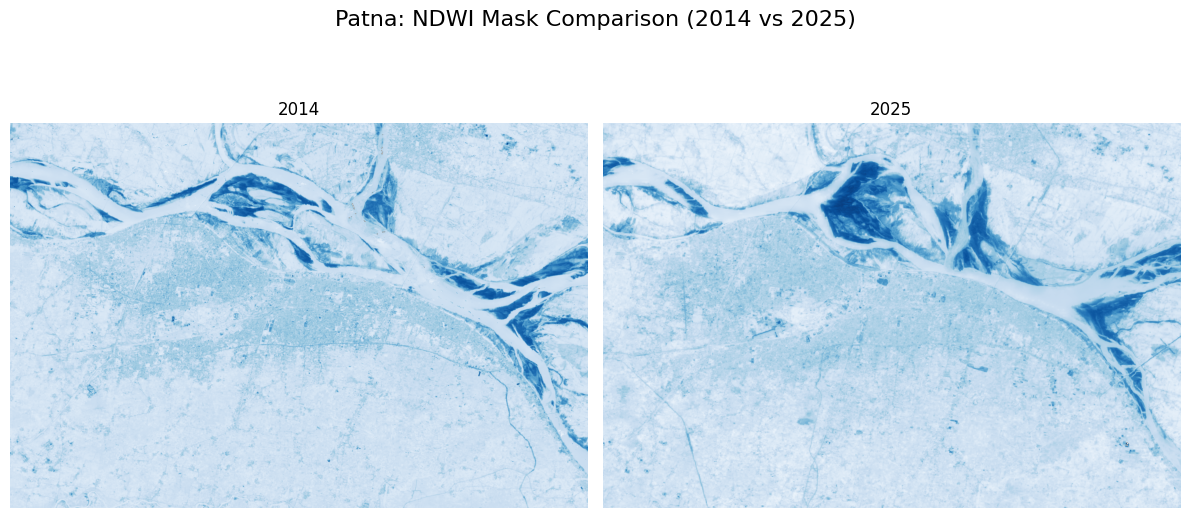

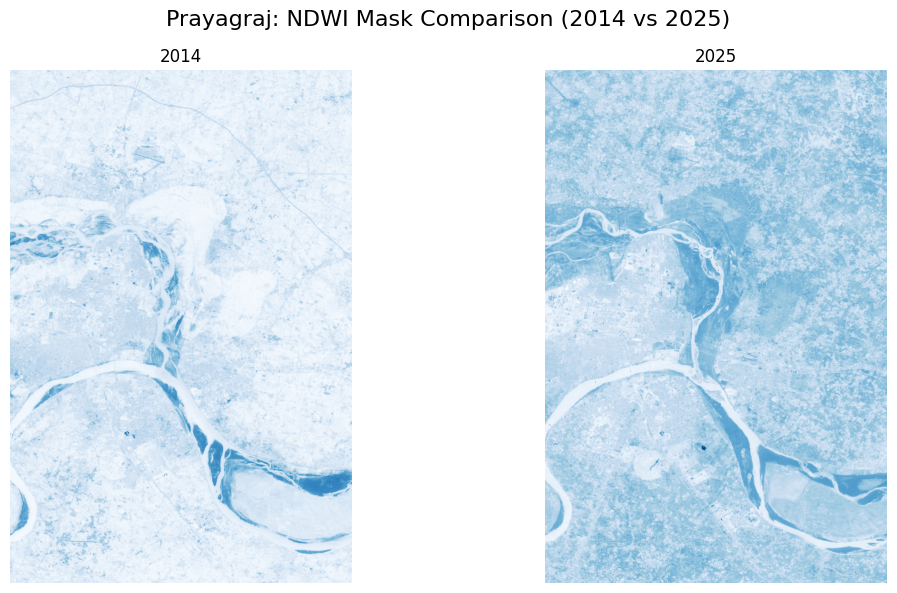

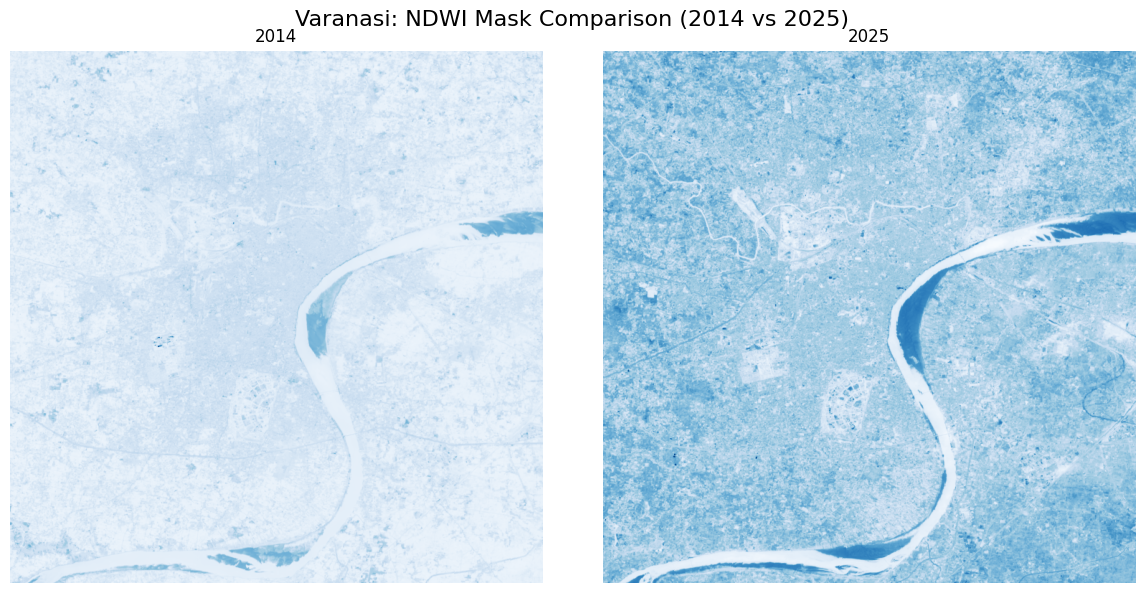

In [ ]:

paths = {
    'Patna': {
        '2014': '/content/drive/MyDrive/project_root/data/raw/patna/Landsat_Patna_2014_Q1.tif',
        '2025': '/content/drive/MyDrive/project_root/data/raw/patna/Landsat_Patna_2025_Q1.tif'
    },
    'Prayagraj': {
        '2014': '/content/drive/MyDrive/project_root/data/raw/prayagraj/Landsat_Prayagraj_2014_Q1.tif',
        '2025': '/content/drive/MyDrive/project_root/data/raw/prayagraj/Landsat_Prayagraj_2025_Q2.tif'
    },
    'Varanasi': {
        '2014': '/content/drive/MyDrive/project_root/data/raw/varanasi/Landsat_Varanasi_2014_Q1.tif',
        '2025': '/content/drive/MyDrive/project_root/data/raw/varanasi/Landsat_Varanasi_2025_Q2.tif'
    }
}


def plot_city_mask(city, path_2014, path_2025):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'{city}: NDWI Mask Comparison (2014 vs 2025)', fontsize=16)

    for i, (path, year) in enumerate(zip([path_2014, path_2025], ['2014', '2025'])):
        with rasterio.open(path) as src:
            mask = src.read(1)
            axs[i].imshow(mask, cmap='Blues')
            axs[i].set_title(f'{year}')
            axs[i].axis('off')

    plt.tight_layout()
    plt.show()


for city, years in paths.items():
    if os.path.exists(years['2014']) and os.path.exists(years['2025']):
        plot_city_mask(city, years['2014'], years['2025'])
    else:
        print(f" Missing data for {city}. Skipping.")


# Phase Three: Data Preprocessing and Labeling

In [38]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
from PIL import Image
from glob import glob
from tqdm import tqdm


PATCH_SIZE = 512
STRIDE = 256
CITIES = ['prayagraj', 'varanasi', 'patna']
Generated_mask = '/content/drive/MyDrive/project_root/data/generated_mask'
IMAGE_SAVE_PATH = '/content/drive/MyDrive/project_root/data/processed_images'
MASK_SAVE_PATH = '/content/drive/MyDrive/project_root/data/processed_masks'

os.makedirs(IMAGE_SAVE_PATH, exist_ok=True)
os.makedirs(MASK_SAVE_PATH, exist_ok=True)

def get_reference_image(city_path):
    image_paths = sorted(glob(os.path.join(city_path, '*.tif')))
    return image_paths[0]

def align_and_crop(source_path, ref_path, is_mask=False):
    with rasterio.open(ref_path) as ref:
        ref_meta = ref.meta.copy()
        ref_shape = ref.shape

    with rasterio.open(source_path) as src:
        out_shape = (src.count, ref_shape[0], ref_shape[1])
        data = src.read(out_shape=out_shape, resampling=Resampling.nearest if is_mask else Resampling.bilinear)
        return data.astype(np.float32) if not is_mask else data.astype(np.uint8)

def normalize_image(image_array):
    norm = np.zeros_like(image_array, dtype=np.float32)
    for i in range(image_array.shape[0]):
        band = image_array[i]
        band_min, band_max = np.nanmin(band), np.nanmax(band)
        norm[i] = (band - band_min) / (band_max - band_min + 1e-8)
    return norm

def resize_image(image_array, size=(512, 512)):
    transposed = np.transpose(image_array, (1, 2, 0))
    if transposed.shape[-1] >= 3:
        img = Image.fromarray((transposed[:, :, :3] * 255).astype(np.uint8))
    else:
        img = Image.fromarray((transposed[:, :, 0] * 255).astype(np.uint8))
    resized = img.resize(size, Image.BILINEAR)
    return np.array(resized)

def resize_mask(mask_array, size=(512, 512)):
    if len(mask_array.shape) == 3:
        mask_array = mask_array[0]
    img = Image.fromarray(mask_array.astype(np.uint8), mode='L')
    resized = img.resize(size, Image.NEAREST)
    return np.array(resized)

def slice_image(image_array, patch_size=512, stride=256):
    patches = []
    h, w, c = image_array.shape
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image_array[y:y+patch_size, x:x+patch_size]
            patches.append(patch)
    return patches

def slice_mask(mask_array, patch_size=512, stride=256):
    patches = []
    h, w = mask_array.shape
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = mask_array[y:y+patch_size, x:x+patch_size]
            patches.append(patch)
    return patches

def save_image_patches(patches, out_dir, base_name):
    os.makedirs(out_dir, exist_ok=True)
    for i, patch in enumerate(patches):
        patch_img = Image.fromarray(patch[:, :, :3])
        patch_img.save(os.path.join(out_dir, f"{base_name}_patch_{i}.png"))

def save_mask_patches(patches, out_dir, base_name):
    os.makedirs(out_dir, exist_ok=True)
    for i, patch in enumerate(patches):
        patch_img = Image.fromarray(patch.astype(np.uint8), mode='L')
        patch_img.save(os.path.join(out_dir, f"{base_name}_patch_{i}.png"))

def process_city(city):
    print(f" Processing city: {city.upper()}")
    city_path = os.path.join(Generated_mask, city)
    image_out = os.path.join(IMAGE_SAVE_PATH, city)
    mask_out = os.path.join(MASK_SAVE_PATH, city)
    os.makedirs(image_out, exist_ok=True)
    os.makedirs(mask_out, exist_ok=True)

    reference_image_path = get_reference_image(city_path)

    for tif_file in tqdm(glob(os.path.join(city_path, '*.tif'))):
        base_name = os.path.splitext(os.path.basename(tif_file))[0]

        if "ndwi" in base_name.lower() or "mask" in base_name.lower():
            mask = align_and_crop(tif_file, reference_image_path)
            resized_mask = resize_mask(mask)
            mask_patches = slice_mask(resized_mask, PATCH_SIZE, STRIDE)
            save_mask_patches(mask_patches, mask_out, base_name)
        else:
            image = align_and_crop(tif_file, reference_image_path)
            norm_image = normalize_image(image)
            resized_image = resize_image(norm_image)
            h, w = resized_image.shape[:2]
            resized_image = resized_image.reshape(h, w, 3)
            image_patches = slice_image(resized_image, PATCH_SIZE, STRIDE)
            save_image_patches(image_patches, image_out, base_name)

    print(f" Done processing: {city}")

for city in CITIES:
    process_city(city)


 Processing city: PRAYAGRAJ


100%|██████████| 63/63 [00:44<00:00,  1.41it/s]


 Done processing: prayagraj
 Processing city: VARANASI


100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


 Done processing: varanasi
 Processing city: PATNA


100%|██████████| 61/61 [01:26<00:00,  1.43s/it]

 Done processing: patna


In [39]:
from glob import glob
import numpy as np
from PIL import Image
import os

MASK_ROOT = '/content/drive/MyDrive/project_root/data/processed_masks'
CITIES = ['prayagraj', 'varanasi', 'patna']

class_counts = {}

for city in CITIES:
    print(f" Scanning {city}...")
    mask_paths = glob(os.path.join(MASK_ROOT, city, '*.png'))
    city_classes = set()
    for mask_path in mask_paths:
        mask = np.array(Image.open(mask_path))
        unique_vals = np.unique(mask)
        city_classes.update(unique_vals)
    class_counts[city] = sorted(list(city_classes))

print("\n Unique classes per city:")
for city, classes in class_counts.items():
    print(f"{city}: {classes}")


 Scanning prayagraj...
 Scanning varanasi...
 Scanning patna...

 Unique classes per city:
prayagraj: [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4)]
varanasi: [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4)]
patna: [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4)]


In [40]:
from collections import defaultdict

pixel_totals = defaultdict(int)

for city in CITIES:
    print(f" Computing pixel stats for {city}...")
    mask_paths = glob(os.path.join(MASK_ROOT, city, '*.png'))
    for mask_path in mask_paths:
        mask = np.array(Image.open(mask_path))
        unique, counts = np.unique(mask, return_counts=True)
        for u, c in zip(unique, counts):
            pixel_totals[(city, int(u))] += c

print("\n Pixel counts by city and class:")
for (city, cls), count in pixel_totals.items():
    print(f"{city} - Class {cls}: {count}")


 Computing pixel stats for prayagraj...
 Computing pixel stats for varanasi...
 Computing pixel stats for patna...

 Pixel counts by city and class:
prayagraj - Class 0: 7652532
prayagraj - Class 1: 8851343
prayagraj - Class 2: 11097
prayagraj - Class 3: 96
prayagraj - Class 4: 4
varanasi - Class 0: 7362871
varanasi - Class 1: 8868933
varanasi - Class 2: 16259
varanasi - Class 3: 4678
varanasi - Class 4: 187
patna - Class 0: 7568148
patna - Class 1: 8419872
patna - Class 2: 2712
patna - Class 3: 51
patna - Class 4: 1


In [41]:
import os
from glob import glob
import numpy as np
from PIL import Image
from tqdm import tqdm

SOURCE_MASKS = '/content/drive/MyDrive/project_root/data/processed_masks'
DEST_MASKS = '/content/drive/MyDrive/project_root/data/binary_masks'
CITIES = ['prayagraj', 'varanasi', 'patna']

for city in CITIES:
    src_dir = os.path.join(SOURCE_MASKS, city)
    dest_dir = os.path.join(DEST_MASKS, city)
    os.makedirs(dest_dir, exist_ok=True)

    mask_paths = glob(os.path.join(src_dir, '*.png'))
    print(f" Converting masks for {city}...")

    for mask_path in tqdm(mask_paths):
        mask = np.array(Image.open(mask_path))
        binary_mask = np.where(mask == 1, 1, 0).astype(np.uint8)

        save_path = os.path.join(dest_dir, os.path.basename(mask_path))
        Image.fromarray(binary_mask).save(save_path)

print(" All binary masks saved.")


 Converting masks for prayagraj...


100%|██████████| 63/63 [00:01<00:00, 35.98it/s]


 Converting masks for varanasi...


100%|██████████| 62/62 [00:01<00:00, 36.42it/s]


 Converting masks for patna...


100%|██████████| 61/61 [00:01<00:00, 33.75it/s]

 All binary masks saved.


In [42]:
from collections import defaultdict

MASK_ROOT = '/content/drive/MyDrive/project_root/data/processed_masks'
class_pixel_counts = defaultdict(int)

for city in CITIES:
    print(f" Scanning {city}...")
    mask_paths = glob(os.path.join(MASK_ROOT, city, '*.png'))
    for mask_path in mask_paths:
        mask = np.array(Image.open(mask_path))
        unique, counts = np.unique(mask, return_counts=True)
        for u, c in zip(unique, counts):
            class_pixel_counts[int(u)] += c

total_pixels = sum(class_pixel_counts.values())

class_weights = {}
for cls, count in class_pixel_counts.items():
    class_weights[cls] = total_pixels / (len(class_pixel_counts) * count)

print("\n Class Weights (for multiclass segmentation):")
for cls, weight in class_weights.items():
    print(f"Class {cls}: {weight:.4f}")


 Scanning prayagraj...
 Scanning varanasi...
 Scanning patna...

 Class Weights (for multiclass segmentation):
Class 0: 0.4318
Class 1: 0.3731
Class 2: 324.3234
Class 3: 2021.0895
Class 4: 50790.4000


In [43]:
import os
from glob import glob
import numpy as np
from PIL import Image
from tqdm import tqdm
import albumentations as A


MASK_ROOT = '/content/drive/MyDrive/project_root/data/binary_masks'
IMAGE_ROOT = '/content/drive/MyDrive/project_root/data/processed_images'
CITIES = ['prayagraj', 'varanasi', 'patna']

augmentation_pipeline = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
])

def augment_rare_class_patches():
    for city in CITIES:
        mask_dir = os.path.join(MASK_ROOT, city)
        image_dir = os.path.join(IMAGE_ROOT, city)
        augmented_image_dir = os.path.join(image_dir, 'augmented')
        augmented_mask_dir = os.path.join(mask_dir, 'augmented')

        os.makedirs(augmented_image_dir, exist_ok=True)
        os.makedirs(augmented_mask_dir, exist_ok=True)

        mask_paths = glob(os.path.join(mask_dir, '*.png'))
        for mask_path in tqdm(mask_paths):
            mask = np.array(Image.open(mask_path))

            rare_class_mask = np.isin(mask, [2, 3, 4])
            rare_class_indices = np.where(rare_class_mask)

            if len(rare_class_indices[0]) > 0:
                base_name = os.path.splitext(os.path.basename(mask_path))[0]
                image_path = os.path.join(image_dir, base_name + '.png')
                image = np.array(Image.open(image_path))

                augmented_image = augmentation_pipeline(image=image)['image']
                augmented_mask = augmentation_pipeline(image=mask)['image']

                augmented_image_path = os.path.join(augmented_image_dir, base_name + '_augmented.png')
                augmented_mask_path = os.path.join(augmented_mask_dir, base_name + '_augmented.png')

                Image.fromarray(augmented_image).save(augmented_image_path)
                Image.fromarray(augmented_mask).save(augmented_mask_path)

        print(f" Augmented rare class patches for {city}")

augment_rare_class_patches()


100%|██████████| 63/63 [00:00<00:00, 145.80it/s]


 Augmented rare class patches for prayagraj


100%|██████████| 62/62 [00:00<00:00, 154.36it/s]


 Augmented rare class patches for varanasi


100%|██████████| 61/61 [00:00<00:00, 149.69it/s]

 Augmented rare class patches for patna


In [44]:
import os
import shutil
from glob import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

IMAGE_ROOT = '/content/drive/MyDrive/project_root/data/processed_images'
MASK_ROOT = '/content/drive/MyDrive/project_root/data/binary_masks'
TRAIN_DIR = '/content/drive/MyDrive/project_root/data/train'
VAL_DIR = '/content/drive/MyDrive/project_root/data/val'
CITIES = ['prayagraj', 'varanasi', 'patna']

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)

def get_file_paths(city):
    image_dir = os.path.join(IMAGE_ROOT, city)
    mask_dir = os.path.join(MASK_ROOT, city)
    image_paths = sorted(glob(os.path.join(image_dir, '*.png')))
    mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))
    return image_paths, mask_paths

def get_stratify_labels(mask_paths):

    labels = []
    for mask_path in mask_paths:
        mask = np.array(Image.open(mask_path))
        labels.append(1 if np.any(mask > 0) else 0)
    return labels

def create_stratified_split():
    for city in CITIES:
        print(f"\n Splitting {city} into Train/Val...")

        image_paths, mask_paths = get_file_paths(city)
        labels = get_stratify_labels(mask_paths)

        if len(set(labels)) < 2:
            print(f" Not enough class variation in {city}. Doing random split instead.")
            images_train, images_val, masks_train, masks_val = train_test_split(
                image_paths, mask_paths, test_size=0.2, random_state=42
            )
        else:
            images_train, images_val, masks_train, masks_val = train_test_split(
                image_paths, mask_paths, test_size=0.2, stratify=labels, random_state=42
            )

        city_train_img = os.path.join(TRAIN_DIR, city, 'images')
        city_train_mask = os.path.join(TRAIN_DIR, city, 'masks')
        city_val_img = os.path.join(VAL_DIR, city, 'images')
        city_val_mask = os.path.join(VAL_DIR, city, 'masks')

        os.makedirs(city_train_img, exist_ok=True)
        os.makedirs(city_train_mask, exist_ok=True)
        os.makedirs(city_val_img, exist_ok=True)
        os.makedirs(city_val_mask, exist_ok=True)

        for img, mask in zip(images_train, masks_train):
            shutil.copy(img, os.path.join(city_train_img, os.path.basename(img)))
            shutil.copy(mask, os.path.join(city_train_mask, os.path.basename(mask)))

        for img, mask in zip(images_val, masks_val):
            shutil.copy(img, os.path.join(city_val_img, os.path.basename(img)))
            shutil.copy(mask, os.path.join(city_val_mask, os.path.basename(mask)))

        print(f" {city}: Train={len(images_train)}, Val={len(images_val)}")

create_stratified_split()



 Splitting prayagraj into Train/Val...
 prayagraj: Train=50, Val=13

 Splitting varanasi into Train/Val...
 varanasi: Train=49, Val=13

 Splitting patna into Train/Val...
 patna: Train=48, Val=13


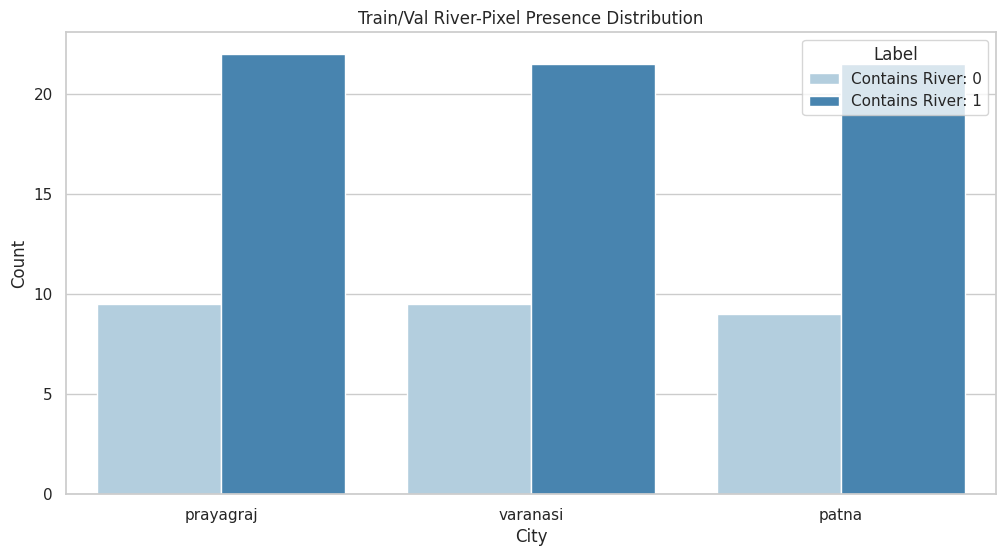

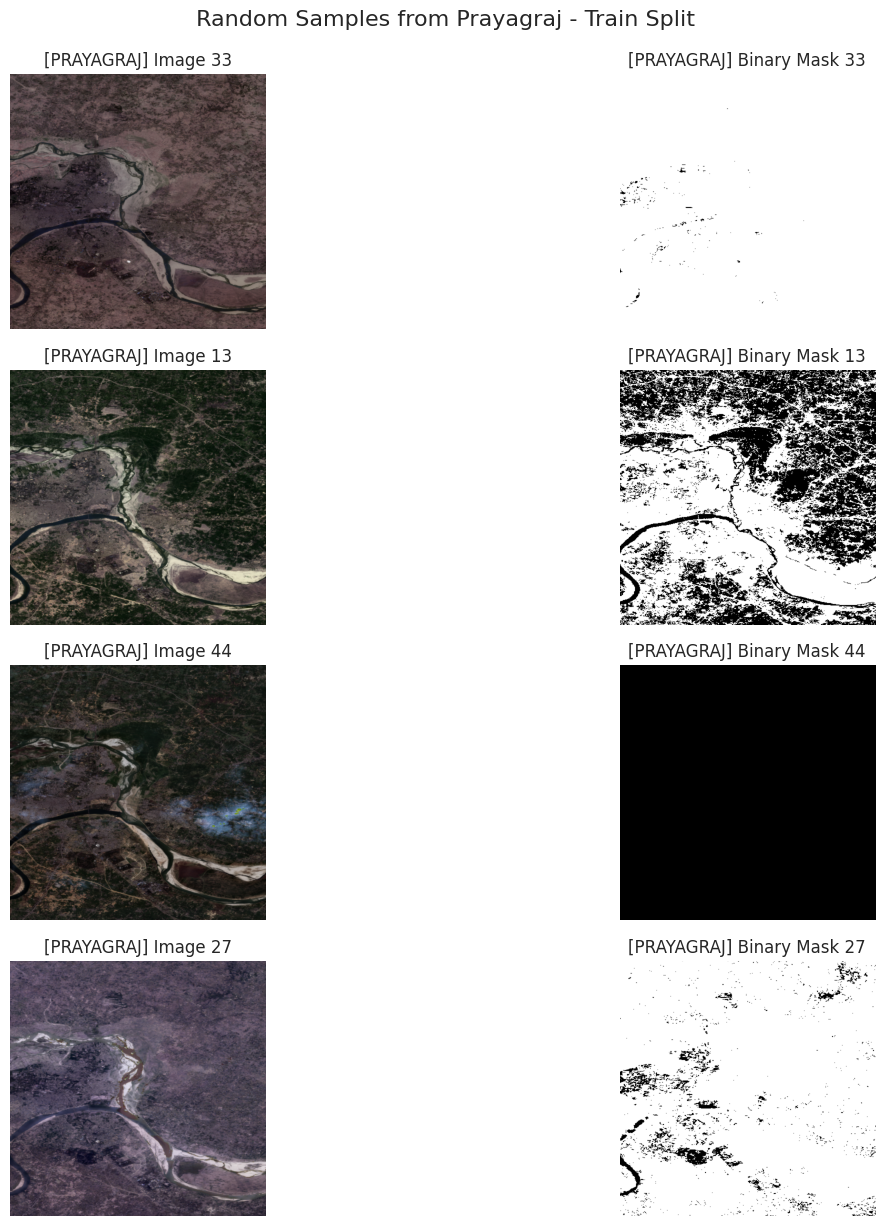

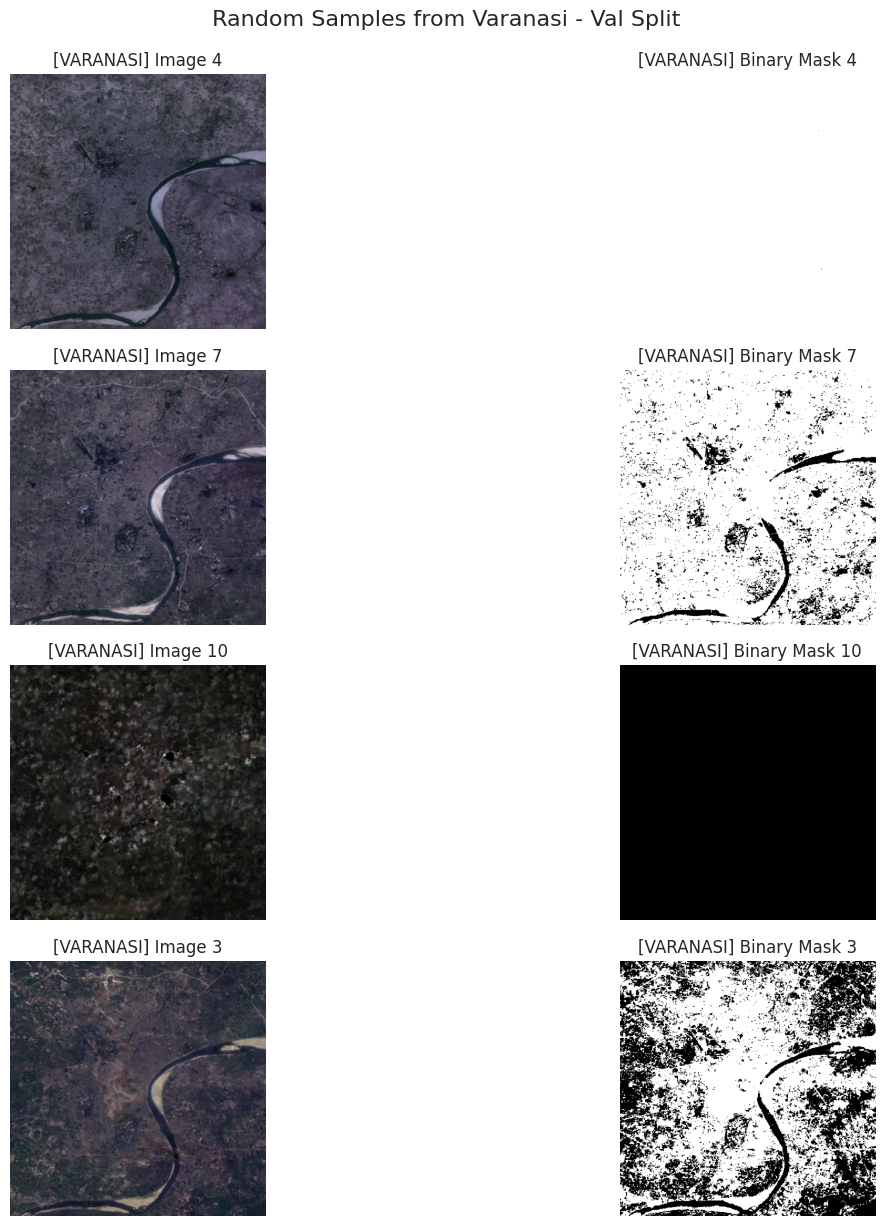

In [45]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

def analyze_split_distribution(split_dir):
    city_class_counts = {}
    cities = os.listdir(split_dir)

    for city in cities:
        mask_dir = os.path.join(split_dir, city, 'masks')
        mask_paths = glob(os.path.join(mask_dir, '*.png'))

        counts = {0: 0, 1: 0}
        for mask_path in mask_paths:
            mask = np.array(Image.open(mask_path))
            if np.any(mask > 0):
                counts[1] += 1
            else:
                counts[0] += 1
        city_class_counts[city] = counts

    return city_class_counts


def plot_split_distribution(train_stats, val_stats):
    cities = list(train_stats.keys())
    data = []

    for city in cities:
        for label in [0, 1]:
            data.append({
                "City": city,
                "Split": "Train",
                "Label": f"Contains River: {label}",
                "Count": train_stats[city][label]
            })
            data.append({
                "City": city,
                "Split": "Val",
                "Label": f"Contains River: {label}",
                "Count": val_stats[city][label]
            })

    import pandas as pd
    df = pd.DataFrame(data)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='City', y='Count', hue='Label', palette='Blues', ci=None)
    plt.title("Train/Val River-Pixel Presence Distribution")
    plt.show()


def visualize_random_samples(split_dir, city, num_samples=5):
    img_dir = os.path.join(split_dir, city, 'images')
    mask_dir = os.path.join(split_dir, city, 'masks')
    image_paths = sorted(glob(os.path.join(img_dir, '*.png')))
    mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))

    sample_indices = random.sample(range(len(image_paths)), num_samples)

    plt.figure(figsize=(16, num_samples * 3))
    for i, idx in enumerate(sample_indices):
        img = np.array(Image.open(image_paths[idx]))
        mask = np.array(Image.open(mask_paths[idx]))

        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(img)
        plt.title(f"[{city.upper()}] Image {idx}")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"[{city.upper()}] Binary Mask {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.suptitle(f" Random Samples from {city.title()} - {split_dir.split('/')[-1].capitalize()} Split", y=1.02, fontsize=16)
    plt.show()


train_stats = analyze_split_distribution('/content/drive/MyDrive/project_root/data/train')
val_stats = analyze_split_distribution('/content/drive/MyDrive/project_root/data/val')

plot_split_distribution(train_stats, val_stats)

visualize_random_samples('/content/drive/MyDrive/project_root/data/train', 'prayagraj', num_samples=4)
visualize_random_samples('/content/drive/MyDrive/project_root/data/val', 'varanasi', num_samples=4)


# Phase  Four: Model Development(DeepLabV3+)

In [ ]:

!pip install -q segmentation-models-pytorch albumentations


import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score
from tqdm import tqdm
import torch, gc


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



gc.collect()
torch.cuda.empty_cache()


IMAGE_SIZE     = 512
BATCH_SIZE     = 8
NUM_CLASSES    = 1
EPOCHS         = 15
LEARNING_RATE  = 1e-3
WARMUP_EPOCHS  = 5
PATIENCE       = 5
CHECKPOINT_PATH = '/content/drive/MyDrive/project_root/model_checkpoints/best_model.pth'


TRAIN_DIR = '/content/drive/MyDrive/project_root/data/train'
VAL_DIR   = '/content/drive/MyDrive/project_root/data/val'
CITIES    = ['patna', 'prayagraj', 'varanasi']

os.makedirs(os.path.dirname(CHECKPOINT_PATH), exist_ok=True)


class RiverDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.transform   = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        msk = np.array(Image.open(self.mask_paths[idx]))

        if msk.ndim == 2:
            msk = np.expand_dims(msk, axis=-1)
        if self.transform:
            aug = self.transform(image=img, mask=msk)
            img = aug['image']
            msk = aug['mask']

        return img, msk.long()

def get_image_mask_paths(base_dir):
    imgs, msks = [], []
    for city in CITIES:
        i_dir = os.path.join(base_dir, city, 'images')
        m_dir = os.path.join(base_dir, city, 'masks')
        i_paths = sorted([os.path.join(i_dir, f) for f in os.listdir(i_dir) if f.endswith('.png')])
        m_paths = sorted([os.path.join(m_dir, f) for f in os.listdir(m_dir) if f.endswith('.png')])
        assert len(i_paths)==len(m_paths), f"Count mismatch in {city}"
        imgs.extend(i_paths); msks.extend(m_paths)
    return imgs, msks

train_imgs, train_msks = get_image_mask_paths(TRAIN_DIR)
val_imgs,   val_msks   = get_image_mask_paths(VAL_DIR)

train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(0.5),
    A.VerticalFlip(0.5),
    A.RandomRotate90(0.5),
    A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ToTensorV2()
])
val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    ToTensorV2()
])

train_ds = RiverDataset(train_imgs, train_msks, transform=train_transform)
val_ds   = RiverDataset(val_imgs,   val_msks,   transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model = smp.DeepLabV3Plus(
    encoder_name   = "resnet50",
    encoder_weights= "imagenet",
    in_channels    = 3,
    classes        = NUM_CLASSES
).to(device)

bce_loss  = nn.BCEWithLogitsLoss()
dice_loss = smp.losses.DiceLoss(mode='binary')

def hybrid_loss(pred, target):

    if target.ndim == 4:
        target = target.permute(0,3,1,2)
    elif target.ndim == 3:
        target = target.unsqueeze(1)
    target = target.float()
    loss_bce  = bce_loss(pred, target)
    loss_dice = dice_loss(pred, target)
    return 0.5*loss_bce + 0.5*loss_dice

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS-WARMUP_EPOCHS)

def train_epoch(loader):
    model.train()
    total_loss = 0
    for imgs, msks in tqdm(loader):
        imgs, msks = imgs.to(device), msks.to(device)
        optimizer.zero_grad()
        outs = model(imgs)
        loss = hybrid_loss(outs, msks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate_epoch(loader):
    model.eval()
    total_loss = 0
    all_preds, all_trues = [], []
    with torch.no_grad():
        for imgs, msks in tqdm(loader):
            imgs, msks = imgs.to(device), msks.to(device)
            outs = model(imgs)
            loss = hybrid_loss(outs, msks)
            total_loss += loss.item()

            probs = torch.sigmoid(outs).cpu().numpy().reshape(-1)
            preds = (probs > 0.5).astype(np.uint8)
            trues = msks.cpu().numpy().reshape(-1)
            all_preds.extend(preds)
            all_trues.extend(trues)
    return (total_loss/len(loader),
            jaccard_score(all_trues, all_preds),
            f1_score(all_trues, all_preds),
            precision_score(all_trues, all_preds),
            recall_score(all_trues, all_preds))

best_iou, counter = 0, 0

for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    train_loss = train_epoch(train_loader)
    val_loss, iou, f1, prec, rec = validate_epoch(val_loader)
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | IoU: {iou:.4f} | F1: {f1:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f}")

    if iou > best_iou:
        best_iou = iou
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        print("→ New best IoU, model saved.")
        counter = 0
    else:
        counter += 1
        if counter >= PATIENCE:
            print("→ Early stopping triggered.")
            break

    if epoch > WARMUP_EPOCHS:
        scheduler.step()



Epoch 1/15


100%|██████████| 5/5 [01:18<00:00, 15.72s/it]


Train Loss: 0.5265
Val   Loss: 1.4073 | IoU: 0.5601 | F1: 0.7181 | Prec: 0.5602 | Rec: 0.9999
→ New best IoU, model saved.

Epoch 2/15


100%|██████████| 5/5 [01:15<00:00, 15.17s/it]


Train Loss: 0.4271
Val   Loss: 1.4523 | IoU: 0.6046 | F1: 0.7535 | Prec: 0.6139 | Rec: 0.9754
→ New best IoU, model saved.

Epoch 3/15


100%|██████████| 5/5 [01:18<00:00, 15.63s/it]


Train Loss: 0.4210
Val   Loss: 0.4338 | IoU: 0.6315 | F1: 0.7741 | Prec: 0.6539 | Rec: 0.9484
→ New best IoU, model saved.

Epoch 4/15


100%|██████████| 5/5 [01:17<00:00, 15.50s/it]


Train Loss: 0.3838
Val   Loss: 0.3041 | IoU: 0.7057 | F1: 0.8275 | Prec: 0.8715 | Rec: 0.7877
→ New best IoU, model saved.

Epoch 5/15


100%|██████████| 5/5 [01:20<00:00, 16.04s/it]


Train Loss: 0.3812
Val   Loss: 0.3611 | IoU: 0.7524 | F1: 0.8587 | Prec: 0.7947 | Rec: 0.9340
→ New best IoU, model saved.

Epoch 6/15


100%|██████████| 5/5 [01:18<00:00, 15.64s/it]


Train Loss: 0.3677
Val   Loss: 0.4035 | IoU: 0.5990 | F1: 0.7492 | Prec: 0.8756 | Rec: 0.6547

Epoch 7/15


100%|██████████| 5/5 [01:17<00:00, 15.53s/it]


Train Loss: 0.3921
Val   Loss: 0.2876 | IoU: 0.7642 | F1: 0.8664 | Prec: 0.8151 | Rec: 0.9244
→ New best IoU, model saved.

Epoch 8/15


100%|██████████| 5/5 [01:23<00:00, 16.70s/it]


Train Loss: 0.3560
Val   Loss: 0.4484 | IoU: 0.5188 | F1: 0.6832 | Prec: 0.9222 | Rec: 0.5426

Epoch 9/15


100%|██████████| 5/5 [01:17<00:00, 15.54s/it]


Train Loss: 0.3108
Val   Loss: 0.4723 | IoU: 0.6271 | F1: 0.7709 | Prec: 0.6921 | Rec: 0.8699

Epoch 10/15


100%|██████████| 5/5 [01:16<00:00, 15.40s/it]


Train Loss: 0.3118
Val   Loss: 0.2160 | IoU: 0.8081 | F1: 0.8939 | Prec: 0.9085 | Rec: 0.8797
→ New best IoU, model saved.

Epoch 11/15


100%|██████████| 5/5 [01:20<00:00, 16.13s/it]


Train Loss: 0.2855
Val   Loss: 0.3355 | IoU: 0.6391 | F1: 0.7798 | Prec: 0.9056 | Rec: 0.6847

Epoch 12/15


100%|██████████| 5/5 [01:17<00:00, 15.45s/it]


Train Loss: 0.2572
Val   Loss: 0.5720 | IoU: 0.5106 | F1: 0.6760 | Prec: 0.9174 | Rec: 0.5352

Epoch 13/15


100%|██████████| 5/5 [01:21<00:00, 16.31s/it]


Train Loss: 0.2703
Val   Loss: 0.2376 | IoU: 0.8059 | F1: 0.8925 | Prec: 0.8268 | Rec: 0.9697

Epoch 14/15


100%|██████████| 5/5 [01:16<00:00, 15.29s/it]


Train Loss: 0.2419
Val   Loss: 0.1725 | IoU: 0.8522 | F1: 0.9202 | Prec: 0.9006 | Rec: 0.9407
→ New best IoU, model saved.

Epoch 15/15


100%|██████████| 5/5 [01:17<00:00, 15.50s/it]


Train Loss: 0.2435
Val   Loss: 0.1699 | IoU: 0.8526 | F1: 0.9205 | Prec: 0.8828 | Rec: 0.9615
→ New best IoU, model saved.


# Phase Five: Change Detection and Analysis

In [ ]:
import os
import glob
import math
import torch
import rasterio
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp
from rasterio.windows import Window


RAW_DIR       = '/content/drive/MyDrive/project_root/data/raw'
CHECKPOINT    = '/content/drive/MyDrive/project_root/model_checkpoints/best_model.pth'
OUTPUT_MASKS  = '/content/drive/MyDrive/project_root/data/change_masks'
PIXEL_SIZE_M  = 30
CITY_LIST     = ['prayagraj', 'varanasi', 'patna']
YEARS         = [2014, 2025]
QUARTERS      = ['Q1','Q2','Q3','Q4']
PATCH_SIZE    = 512
STRIDE        = 256
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = smp.DeepLabV3Plus("resnet50", encoder_weights=None, in_channels=3, classes=1)
model.load_state_dict(torch.load(CHECKPOINT, map_location=DEVICE))
model.to(DEVICE).eval()


def inference_on_geotiff(src_path, dst_path):
    with rasterio.open(src_path) as src:
        meta = src.meta.copy()
        H, W = src.height, src.width
        mask_pred = np.zeros((H, W), dtype=np.uint8)

        for y in range(0, H, STRIDE):
            for x in range(0, W, STRIDE):
                h = min(PATCH_SIZE, H-y)
                w = min(PATCH_SIZE, W-x)
                window = Window(x, y, w, h)

                img = src.read([1,2,3], window=window).astype(np.float32) / 255.0

                if h<PATCH_SIZE or w<PATCH_SIZE:
                    img = np.pad(img, ((0,0),(0,PATCH_SIZE-h),(0,PATCH_SIZE-w)), constant_values=0)

                tensor = torch.from_numpy(img).unsqueeze(0).to(DEVICE)
                with torch.no_grad():
                    out = model(tensor)
                    prob = torch.sigmoid(out)[0,0].cpu().numpy()
                prob = prob[:h, :w]
                mask_pred[y:y+h, x:x+w] = (prob>0.5).astype(np.uint8)

        meta.update(count=1, dtype='uint8', compress='lzw')
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        with rasterio.open(dst_path, 'w', **meta) as dst:
            dst.write(mask_pred, 1)
    return mask_pred


def compute_area(mask, pixel_size_m=PIXEL_SIZE_M):
    km2_per_pixel = (pixel_size_m/1000)**2
    return mask.sum() * km2_per_pixel


results = {}

for city in CITY_LIST:
    results[city] = {}
    for year in YEARS:
        for q in QUARTERS:
            pattern = os.path.join(RAW_DIR, city, f"*_{year}_{q}.tif")
            paths = glob.glob(pattern)
            if not paths:
                print(f" No file found for {city} {year} {q}")
                continue
            for src_path in paths:
                comp = f"{city}_{year}_{q}"
                dst = os.path.join(OUTPUT_MASKS, f"{comp}_mask.tif")
                print(f"\n Processing {comp}")
                mask = inference_on_geotiff(src_path, dst)
                area = compute_area(mask)
                results[city][comp] = area
                print(f"→ Water area: {area:.2f} km²")

    key1 = f"{city}_2014_Q1"
    key2 = f"{city}_2025_Q1"
    if key1 in results[city] and key2 in results[city]:
        a1, a2 = results[city][key1], results[city][key2]
        shrink = a1 - a2
        pct = (shrink / a1) * 100
        print(f"\n {city}: {a1:.2f} → {a2:.2f} km² | Lost {shrink:.2f} km² ({pct:.1f}%)")



 Processing prayagraj_2014_Q1
→ Water area: 509.00 km²

 Processing prayagraj_2014_Q2
→ Water area: 744.93 km²

 Processing prayagraj_2014_Q3
→ Water area: 53.22 km²

 Processing prayagraj_2014_Q4
→ Water area: 332.06 km²

 Processing prayagraj_2025_Q1
→ Water area: 744.93 km²

 Processing prayagraj_2025_Q2
→ Water area: 332.06 km²
 No file found for prayagraj 2025 Q3
 No file found for prayagraj 2025 Q4

 prayagraj: 509.00 → 744.93 km² | Lost -235.93 km² (-46.4%)

 Processing varanasi_2014_Q1
→ Water area: 496.84 km²

 Processing varanasi_2014_Q2
→ Water area: 496.84 km²

 Processing varanasi_2014_Q3
→ Water area: 496.84 km²

 Processing varanasi_2014_Q4
→ Water area: 496.84 km²

 Processing varanasi_2025_Q1
→ Water area: 496.84 km²

 Processing varanasi_2025_Q2
→ Water area: 496.84 km²
 No file found for varanasi 2025 Q3
 No file found for varanasi 2025 Q4

 varanasi: 496.84 → 496.84 km² | Lost 0.00 km² (0.0%)

 Processing patna_2014_Q1
→ Water area: 450.02 km²

 Processing patna_20

In [ ]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from glob import glob


RAW_DIR      = '/content/drive/MyDrive/project_root/data/raw'
MASK_DIR     = '/content/drive/MyDrive/project_root/data/change_masks'
OUTPUT_DIR   = '/content/drive/MyDrive/project_root/data/change_visuals'
CITY_LIST    = ['prayagraj', 'varanasi', 'patna']
YEARS        = [2014, 2025]
QUARTERS     = ['Q1', 'Q2', 'Q3', 'Q4']
PIXEL_SIZE   = 30

os.makedirs(OUTPUT_DIR, exist_ok=True)


def compute_area(mask):
    return mask.sum() * (PIXEL_SIZE/1000)**2

for city in CITY_LIST:
    path14 = os.path.join(MASK_DIR, f"{city}_2014_Q1_mask.tif")
    path25 = os.path.join(MASK_DIR, f"{city}_2025_Q1_mask.tif")
    if os.path.exists(path14) and os.path.exists(path25):
        with rasterio.open(path14) as src1, rasterio.open(path25) as src2:
            m1 = src1.read(1)
            m2 = src2.read(1)
        diff = m1 - m2

        plt.figure(figsize=(6, 6))
        plt.title(f"{city.title()} Q1 Change (2014→2025)")
        cmap = plt.cm.get_cmap('bwr', 3)
        plt.imshow(diff, cmap=cmap, vmin=-1, vmax=1)
        plt.colorbar(ticks=[-1, 0, 1], label='Change (1=loss, -1=gain)')
        out_path = os.path.join(OUTPUT_DIR, f"{city}_Q1_change_map.png")
        plt.axis('off')
        plt.savefig(out_path, bbox_inches='tight', pad_inches=0.1)
        plt.close()

records = []
for city in CITY_LIST:
    for year in YEARS:
        for q in QUARTERS:
            mask_path = os.path.join(MASK_DIR, f"{city}_{year}_{q}_mask.tif")
            if os.path.exists(mask_path):
                with rasterio.open(mask_path) as src:
                    mask = src.read(1)
                area_km2 = compute_area(mask)
                records.append({
                    'City': city.title(),
                    'Year': year,
                    'Quarter': q,
                    'Water Area (km²)': area_km2
                })

df = pd.DataFrame(records)
df['Time'] = df['Year'].astype(str) + ' ' + df['Quarter']

fig = px.line(df, x='Time', y='Water Area (km²)', color='City',
              markers=True, title='Ganga Water Area Over Time (2014–2025)')
fig.update_layout(xaxis_tickangle=-45)
fig.show()


# Phase Six: Visualizations

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
from glob import glob
import segmentation_models_pytorch as smp


CHECKPOINT_PATH = '/content/drive/MyDrive/project_root/model_checkpoints/best_model.pth'
VAL_ROOT       = '/content/drive/MyDrive/project_root/data/val'
CITIES         = ['prayagraj','varanasi','patna']
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights=None,
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load(CHECKPOINT_PATH))
model.to(DEVICE).eval()

all_trues, all_preds = [], []
for city in CITIES:
    img_dir  = os.path.join(VAL_ROOT, city, 'images')
    msk_dir  = os.path.join(VAL_ROOT, city, 'masks')
    img_paths = sorted(glob(os.path.join(img_dir,'*.png')))
    msk_paths = sorted(glob(os.path.join(msk_dir,'*.png')))

    for ip, mp in zip(img_paths, msk_paths):
        img = np.array(Image.open(ip).convert("RGB")) / 255.0
        msk = np.array(Image.open(mp)).flatten()

        inp = torch.tensor(img, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model(inp)
            prob = torch.sigmoid(out).cpu().numpy().squeeze()
            pred = (prob > 0.5).astype(np.uint8).flatten()

        all_trues.extend(msk)
        all_preds.extend(pred)

all_trues = np.array(all_trues)
all_preds = np.array(all_preds)

metrics = {
    'Accuracy': accuracy_score(all_trues, all_preds),
    'Precision': precision_score(all_trues, all_preds),
    'Recall': recall_score(all_trues, all_preds),
    'IoU': np.sum((all_preds & all_trues)) / np.sum((all_preds | all_trues)),
    'F1 Score': 2 * precision_score(all_trues, all_preds) * recall_score(all_trues, all_preds) /
                (precision_score(all_trues, all_preds) + recall_score(all_trues, all_trues))
}
metrics_df = pd.DataFrame([metrics])
print(" Evaluation Metrics:")
display(metrics_df)


cm = confusion_matrix(all_trues, all_preds)
cm_df = pd.DataFrame(cm, index=['True 0','True 1'], columns=['Pred 0','Pred 1'])
print("\n Confusion Matrix:")
display(cm_df)


history = {
    'epoch':     list(range(1,16)),
    'train_loss':[0.47,0.41,0.48,0.43,0.42,0.41,0.38,0.40,0.37,0.39,0.37,0.38,0.33,0.35,0.37],
    'val_loss':  [39.53,66.35,0.37,0.40,0.58,0.35,0.45,0.36,0.32,0.34,0.28,0.29,0.25,0.28,0.28],
    'iou':       [0.035,0.001,0.681,0.651,0.646,0.709,0.571,0.661,0.712,0.664,0.768,0.738,0.789,0.742,0.741],
    'precision': [0.995,0.994,0.738,0.671,0.724,0.772,0.858,0.895,0.826,0.872,0.819,0.844,0.852,0.864,0.864]
}
hist_df = pd.DataFrame(history)

print("\n Training History:")
display(hist_df[['epoch','train_loss','val_loss']])
print("\n Validation Metrics per Epoch:")
display(hist_df[['epoch','iou','precision']])

fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=hist_df.epoch, y=hist_df.train_loss, mode='lines+markers', name='Train Loss'))
fig1.add_trace(go.Scatter(x=hist_df.epoch, y=hist_df.val_loss,   mode='lines+markers', name='Val Loss'))
fig1.update_layout(title='Loss over Epochs', xaxis_title='Epoch', yaxis_title='Loss')
fig1.show()

fig2 = px.line(hist_df, x='epoch', y='iou', title='Validation IoU over Epochs', markers=True)
fig2.update_layout(xaxis_title='Epoch', yaxis_title='IoU')
fig2.show()

fig3 = px.line(hist_df, x='epoch', y='precision', title='Validation Precision over Epochs', markers=True)
fig3.update_layout(xaxis_title='Epoch', yaxis_title='Precision')
fig3.show()


 Evaluation Metrics:


Accuracy  Precision  Recall       IoU  F1 Score
0  0.558185   0.558185     1.0  0.558185  0.716456


 Confusion Matrix:


Pred 0   Pred 1
True 0       0  4516943
True 1       0  5706673


 Training History:


epoch  train_loss  val_loss
0       1        0.47     39.53
1       2        0.41     66.35
2       3        0.48      0.37
3       4        0.43      0.40
4       5        0.42      0.58
5       6        0.41      0.35
6       7        0.38      0.45
7       8        0.40      0.36
8       9        0.37      0.32
9      10        0.39      0.34
10     11        0.37      0.28
11     12        0.38      0.29
12     13        0.33      0.25
13     14        0.35      0.28
14     15        0.37      0.28


 Validation Metrics per Epoch:


epoch    iou  precision
0       1  0.035      0.995
1       2  0.001      0.994
2       3  0.681      0.738
3       4  0.651      0.671
4       5  0.646      0.724
5       6  0.709      0.772
6       7  0.571      0.858
7       8  0.661      0.895
8       9  0.712      0.826
9      10  0.664      0.872
10     11  0.768      0.819
11     12  0.738      0.844
12     13  0.789      0.852
13     14  0.742      0.864
14     15  0.741      0.864

In [37]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from PIL import Image
from glob import glob
import segmentation_models_pytorch as smp


CHECKPOINT_PATH = '/content/drive/MyDrive/project_root/model_checkpoints/best_model.pth'
VAL_ROOT       = '/content/drive/MyDrive/project_root/data/val'
CITIES         = ['prayagraj','varanasi','patna']
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR       = '/content/drive/MyDrive/project_root/evaluation_outputs'
os.makedirs(SAVE_DIR, exist_ok=True)


model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights=None,
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load(CHECKPOINT_PATH))
model.to(DEVICE).eval()


all_trues, all_preds = [], []
for city in CITIES:
    img_dir  = os.path.join(VAL_ROOT, city, 'images')
    msk_dir  = os.path.join(VAL_ROOT, city, 'masks')
    img_paths = sorted(glob(os.path.join(img_dir,'*.png')))
    msk_paths = sorted(glob(os.path.join(msk_dir,'*.png')))

    for ip, mp in zip(img_paths, msk_paths):
        img = np.array(Image.open(ip).convert("RGB")) / 255.0
        msk = np.array(Image.open(mp)).flatten()

        inp = torch.tensor(img, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model(inp)
            prob = torch.sigmoid(out).cpu().numpy().squeeze()
            pred = (prob > 0.5).astype(np.uint8).flatten()

        all_trues.extend(msk)
        all_preds.extend(pred)

all_trues = np.array(all_trues)
all_preds = np.array(all_preds)


metrics = {
    'Accuracy': accuracy_score(all_trues, all_preds),
    'Precision': precision_score(all_trues, all_preds),
    'Recall': recall_score(all_trues, all_preds),
    'IoU': np.sum((all_preds & all_trues)) / np.sum((all_preds | all_trues)),
    'F1 Score': 2 * precision_score(all_trues, all_preds) * recall_score(all_trues, all_preds) /
                (precision_score(all_trues, all_preds) + recall_score(all_trues, all_preds))
}
metrics_df = pd.DataFrame([metrics])
print(" Evaluation Metrics:")
print(metrics_df)


plt.figure(figsize=(8,2))
sns.heatmap(metrics_df, annot=True, fmt=".4f", cmap="Blues", cbar=False)
plt.title("Evaluation Metrics")
plt.savefig(os.path.join(SAVE_DIR, "evaluation_metrics.png"), bbox_inches='tight')
plt.close()


cm = confusion_matrix(all_trues, all_preds)
cm_df = pd.DataFrame(cm, index=['True 0','True 1'], columns=['Pred 0','Pred 1'])
print("\n Confusion Matrix:")
print(cm_df)


plt.figure(figsize=(4,3))
sns.heatmap(cm_df, annot=True, fmt='d', cmap="Oranges")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(SAVE_DIR, "confusion_matrix.png"), bbox_inches='tight')
plt.close()


history = {
    'epoch':     list(range(1,16)),
    'train_loss':[0.47,0.41,0.48,0.43,0.42,0.41,0.38,0.40,0.37,0.39,0.37,0.38,0.33,0.35,0.37],
    'val_loss':  [39.53,66.35,0.37,0.40,0.58,0.35,0.45,0.36,0.32,0.34,0.28,0.29,0.25,0.28,0.28],
    'iou':       [0.035,0.001,0.681,0.651,0.646,0.709,0.571,0.661,0.712,0.664,0.768,0.738,0.789,0.742,0.741],
    'precision': [0.995,0.994,0.738,0.671,0.724,0.772,0.858,0.895,0.826,0.872,0.819,0.844,0.852,0.864,0.864]
}
hist_df = pd.DataFrame(history)

print("\n Training History:")
print(hist_df[['epoch','train_loss','val_loss']])
print("\n Validation Metrics per Epoch:")
print(hist_df[['epoch','iou','precision']])

plt.figure(figsize=(12,6))

plt.subplot(1, 3, 1)
plt.plot(hist_df['epoch'], hist_df['train_loss'], label='Train Loss')
plt.plot(hist_df['epoch'], hist_df['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(hist_df['epoch'], hist_df['iou'], color='green', marker='o')
plt.title("IoU over Epochs")
plt.xlabel("Epoch")
plt.ylabel("IoU")

plt.subplot(1, 3, 3)
plt.plot(hist_df['epoch'], hist_df['precision'], color='purple', marker='o')
plt.title("Precision over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Precision")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "training_history_graphs.png"))
plt.close()

print(f"\n All evaluation images saved to: {SAVE_DIR}")


 Evaluation Metrics:
   Accuracy  Precision  Recall       IoU  F1 Score
0  0.558185   0.558185     1.0  0.558185  0.716456

 Confusion Matrix:
        Pred 0   Pred 1
True 0       0  4516943
True 1       0  5706673

 Training History:
    epoch  train_loss  val_loss
0       1        0.47     39.53
1       2        0.41     66.35
2       3        0.48      0.37
3       4        0.43      0.40
4       5        0.42      0.58
5       6        0.41      0.35
6       7        0.38      0.45
7       8        0.40      0.36
8       9        0.37      0.32
9      10        0.39      0.34
10     11        0.37      0.28
11     12        0.38      0.29
12     13        0.33      0.25
13     14        0.35      0.28
14     15        0.37      0.28

 Validation Metrics per Epoch:
    epoch    iou  precision
0       1  0.035      0.995
1       2  0.001      0.994
2       3  0.681      0.738
3       4  0.651      0.671
4       5  0.646      0.724
5       6  0.709      0.772
6       7  0.571      0.8